# sacfc - All products
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 24, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 31 # sacfc
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMLS].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(11655, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11655 entries, 0 to 11654
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            11655 non-null  int64  
 1   dimCustomerMasterId     11655 non-null  int64  
 2   customerNumber          767 non-null    object 
 3   year                    11655 non-null  int64  
 4   productGrouping         11655 non-null  object 
 5   totalSpent              11655 non-null  float64
 6   recentDate              11655 non-null  object 
 7   attendancePercent       11655 non-null  float64
 8   renewedBeforeDays       11655 non-null  int64  
 9   isBuyer                 11655 non-null  object 
 10  source_tenure           11655 non-null  int64  
 11  tenure                  11655 non-null  int64  
 12  distToVenue             0 non-null      object 
 13  totalGames              11655 non-null  int64  
 14  recency                 11655 non-null

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
                "attendancePercent",
                "distToVenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays",
                "isNextYear_Buyer",
                "productGrouping",
                "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (5622, 13)
Unseen Data For Predictions: (992, 13)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "attendancePercent",
                "distToVenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7551,0.7292,0.8998,0.7926,0.8427,0.2993,0.3123,0.7660
lr,Logistic Regression,0.7403,0.6949,0.9535,0.7549,0.8426,0.1531,0.1964,0.4570


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7845,0.7587,0.9198,0.8106,0.8617,0.3823,0.3984
1,0.7238,0.6939,0.8682,0.7789,0.8211,0.2234,0.2298
2,0.7510,0.7050,0.8883,0.7949,0.8390,0.2979,0.3071
3,0.7573,0.7335,0.9198,0.7848,0.8470,0.2784,0.3001
4,0.7762,0.7632,0.8994,0.8130,0.8540,0.3794,0.3885
5,0.7490,0.6958,0.9080,0.7822,0.8404,0.2672,0.2843
6,0.7218,0.7028,0.8822,0.7694,0.8220,0.1989,0.2090
7,0.7762,0.7554,0.9080,0.8082,0.8552,0.3694,0.3819
8,0.7463,0.7441,0.8937,0.7873,0.8371,0.2739,0.2855
9,0.7652,0.7398,0.9109,0.7965,0.8499,0.3223,0.3382


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(2944, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
8711,31,457921203,0,2021,Full Season,2306.88,2021-10-17,0.477273,402,TRUE,...,0,0,0.00,1,24,0,0,1,0.0110,0.9890
8712,31,457921287,0,2021,Full Season,966.72,1970-01-01,0.000000,402,TRUE,...,0,0,468.28,1,24,0,0,1,0.2824,0.7176
8713,31,457921457,107097,2021,Full Season,72.22,2021-10-13,1.000000,511,TRUE,...,0,0,0.00,1,24,0,0,0,0.6128,0.3872
8714,31,457921646,234153,2021,Full Season,105.56,2021-10-17,0.500000,511,TRUE,...,0,0,0.00,1,24,0,0,1,0.1968,0.8032
8715,31,457922282,0,2021,Full Season,292.04,2021-06-26,0.312500,10,TRUE,...,0,0,0.00,1,24,0,0,0,0.6403,0.3597


In [11]:
new_predictions["Label"].value_counts()

1    2114
0     830
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(0.8, 1.0]       1669
(-0.001, 0.2]     339
(0.2, 0.4]        330
(0.4, 0.6]        303
(0.6, 0.8]        303
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

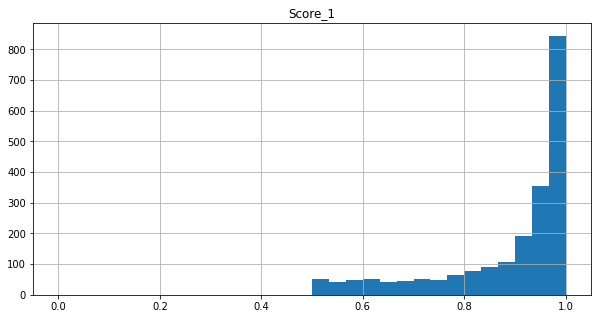

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

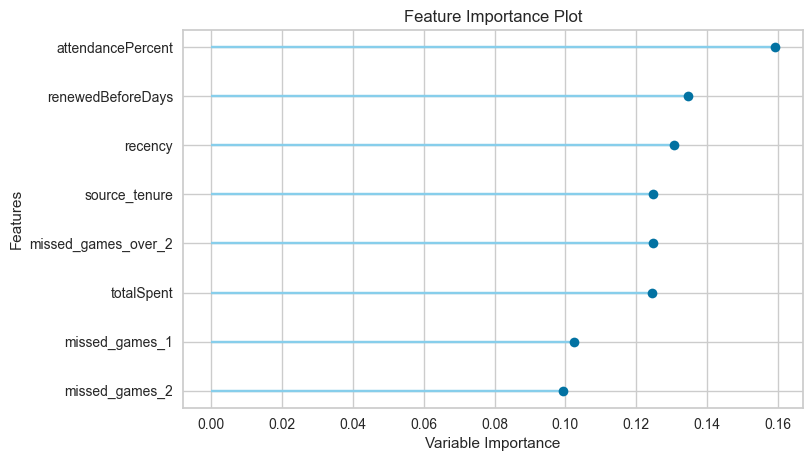

In [14]:
plot_model(best_model, plot='feature')

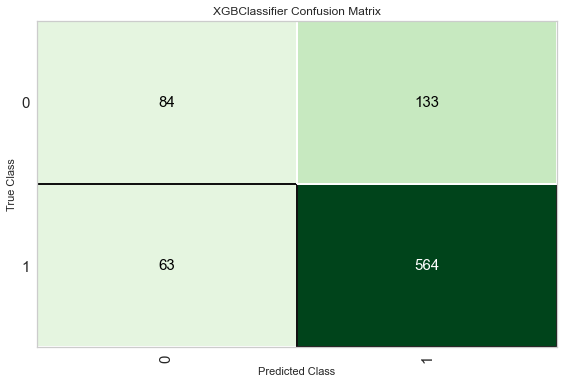

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?